---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---

# Assignment Summary

In this activity, you are required to apply the knowledge acquired in this module through the design and development of a complete project for deep learning-based image pattern recognition in an application to be defined by yourself. For this, you will need to perform the following **mandatory** steps:

1. [Problem definition](#scrollTo=hglJVRRslqMn)
2. [GitHub repository](#scrollTo=ecxDhkV9qmUf)
3. [Dataset](#scrollTo=qEgFzxmWrGA9)
4. [Dataloader](#scrollTo=EDd6lLwlx4un)
5. [Proposed solution](#scrollTo=ScTrpUW8zOp4)
6. [Experimental tests and evaluations](#scrollTo=3RBW58of0ZDo)
7. [Quiz and Report](#scrollTo=ws14iV4Dp_vf)
8. [Demonstration session](#scrollTo=ShLJrPKT4SQp)


------
# 1. **Problem definition** 

The Computer Vision task that we have selected for this project is **Object Detection** and the application is **Street Litter Detection**.

Two different cities were chosen to collect the dataset:

**City A**: Falkirk, Scotland, UK; Coordinates: 56.0019° N, 3.7839° W

**City B**: Punalur, Kerala, India; Coordinates: 9.0176° N, 76.9261° E

It was made sure that the dataset images are free from any sensitive informations like faces of people or vehicle number plate information.


---
# 2. **GitHub repository**

A Github repository named: ITNPAI1-Street-Litter-Detection was created for the project.

**Repo Link**: https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection

In [1]:
#Importing necessary modules and libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf


In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random
#import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
#Importing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Setting file paths in drive
path = '/content/drive/MyDrive/CourseWork/Deeplearning for Vision and NLP/litter_detection_model'

#raw images
raw_image_path = path + '/raw_images'
punalur_falkirk_raw_image_path = raw_image_path + '/Falkirk_Punalur/'
falkirk_raw_image_path = raw_image_path + '/Falkirk'

#annotated images
annotated_image_path = path + '/annotated_images'
punalur_falkirk_annotated_image_path = annotated_image_path + '/Falkirk_Punalur/'
falkirk_annotated_image_path = annotated_image_path + '/Falkirk'


In [6]:
#Storing the raw Images names list
punalur_falkirk_raw_images = [image for image in os.listdir(raw_image_path+'/Falkirk_Punalur/')]

In [7]:
# Image Resize function :: To be reused throughout the code.
def resize_image(img, shape):
    resized_img = cv2.resize(img, shape)
    return resized_img


## Validating the dataset path and Image plotting techniques

(1848, 4000, 3)
(224, 224, 3)


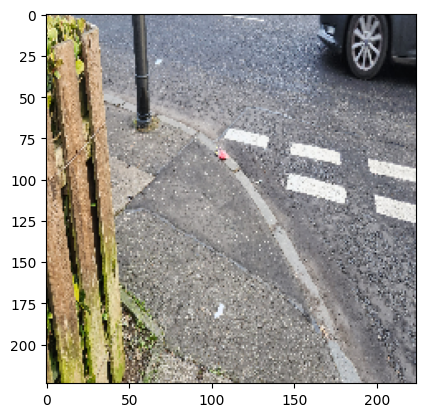

In [8]:

#Choosing a random image from the list of Image names
test_img = punalur_falkirk_raw_images[15] #Randomly decided on index 20

test_img = cv2.imread(punalur_falkirk_raw_image_path + test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
print(test_img.shape)

resized_img = resize_image(test_img, (224, 224))
print(resized_img.shape)

#Resizing and Normalizing the test Image
test_img = resized_img.copy()
test_img = ((test_img - test_img.min()) / (test_img.max() - test_img.min())) * 255
test_img = test_img.astype(np.uint8)
plt.imshow(test_img)


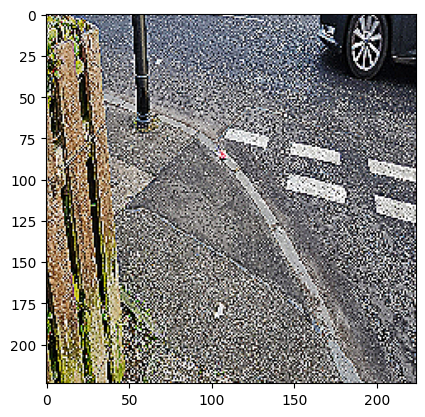

In [9]:
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

image_sharpened = cv2.filter2D(test_img, -1, kernel)
# plt.imshow(test_img)


# #Histogram Equalization(Contrast Enhancement)
image_in_yuv = cv2.cvtColor(image_sharpened, cv2.COLOR_BGR2YUV)
image_in_yuv[:, :, 0] = cv2.equalizeHist(image_in_yuv[:, :, 0])

image_back_in_rgb = cv2.cvtColor(image_in_yuv, cv2.COLOR_YUV2BGR)
plt.imshow(image_back_in_rgb)

In [10]:
""" This function will perform all the preprocessing steps required for the images """


def perform_image_preprocessing(image):
    # Normalizing the Image
    image = ((image - image.min()) / (image.max() - image.min())) * 255
    image = image.astype(np.uint8)

    

    #Histogram Equalization(Contrast Enhancement)
    image_in_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image_in_yuv[:, :, 0] = cv2.equalizeHist(image_in_yuv[:, :, 0])

    image_back_in_rgb = cv2.cvtColor(image_in_yuv, cv2.COLOR_YUV2BGR)

    return image_back_in_rgb


In [11]:
"""This function will extract the top left and bottom right coordinates (x1, y1, x2, y2) 
from the .txt annotated file coordinates"""

def get_rectangle_coordinates_from_image(image, x_center, y_center, height, width):
    
    H, W, _ = image.shape
    x1 = int((x_center - width / 2) * W)
    y1 = int((y_center - height / 2) * H)
    x2 = int((x_center + width / 2) * W)
    y2 = int((y_center + 3 * height / 2) * H)
    return x1, y1, x2, y2


In [12]:
"""This block of code ensures all the .txt labeled files are read as Pandas DataFrames
with appropriate column names"""

txt_files = [f for f in os.listdir(punalur_falkirk_annotated_image_path) if f.lower().endswith('.txt')]

# Making sure the label class file is removed before further processing

try:
    txt_files.remove('classes.txt')
except ValueError:
    print(f'classes.txt not present')

# Reading the content of each .txt file

annotated_punalur_falkirk_files = []
for txt_file in txt_files:
    # print(txt_file)
    file_path = os.path.join(punalur_falkirk_annotated_image_path, txt_file)
    with open(file_path, 'r') as f:
        cols = ['label_class', 'x_center', 'y_center', 'width', 'height']
        content = pd.read_csv(f, sep=' ', names=cols)
        annotated_punalur_falkirk_files.append({txt_file: content})

print(len(annotated_punalur_falkirk_files))


classes.txt not present
229


In [13]:
"""Region Proposal Using Selective Search algorithm """


def perform_region_proposal(image):
    # Perform region proposals using Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    # ss.switchToSelectiveSearchFast()
    ss.switchToSelectiveSearchQuality()
    regions = ss.process()
    return regions


In [14]:
"""Function to Calculate the Intersection of Region (IOU) between two dictionary of coordinates passed"""


def calculate_iou(box1, box2):
    # Calculate intersection area
    x1 = max(box1['x1'], box2['x1'])
    y1 = max(box1['y1'], box2['y1'])
    x2 = min(box1['x2'], box2['x2'])
    y2 = min(box1['y2'], box2['y2'])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1['x2'] - box1['x1'] + 1) * (box1['y2'] - box1['y1'] + 1)
    box2_area = (box2['x2'] - box2['x1'] + 1) * (box2['y2'] - box2['y1'] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou



## Validating the logic for extracting .txt annotated file coordinates

20230304_133137.txt
check
96 83 107 124
(224, 224, 3)


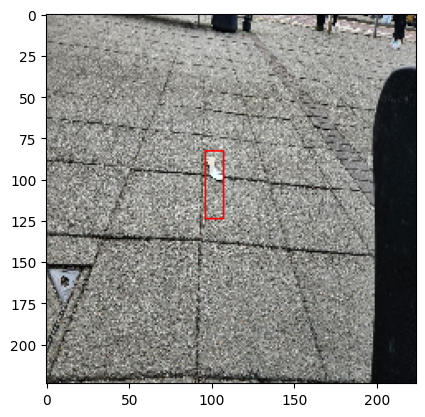

20230304_142514.txt
check
82 95 106 123
check
144 71 154 78
check
198 80 212 87
check
74 137 89 150
check
3 198 19 216
(224, 224, 3)


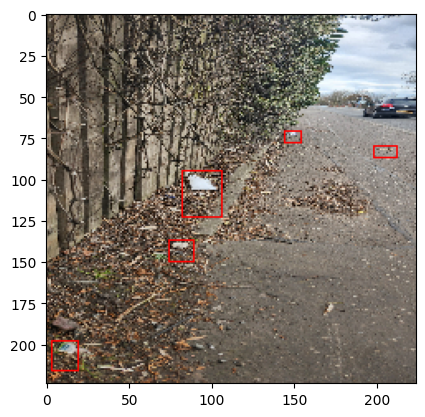

20230304_142518.txt
check
88 77 118 119
(224, 224, 3)


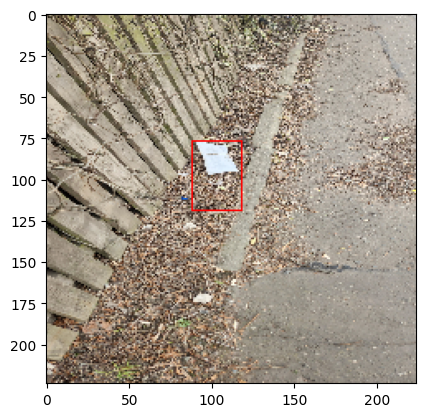

20230304_142525.txt
check
92 36 120 54
check
90 128 134 175
(224, 224, 3)


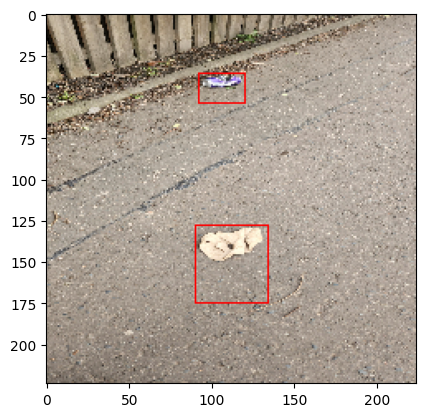

20230304_142535.txt
check
90 86 154 101
check
120 94 140 105
check
129 83 137 91
(224, 224, 3)


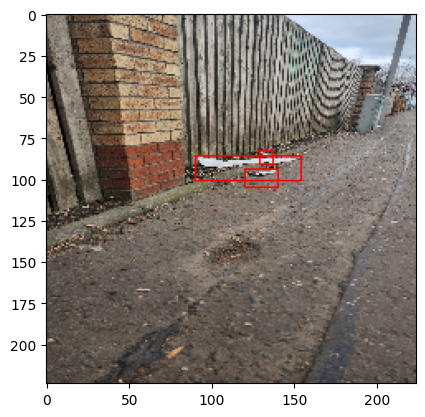

20230304_142550.txt
check
99 101 121 121
(224, 224, 3)


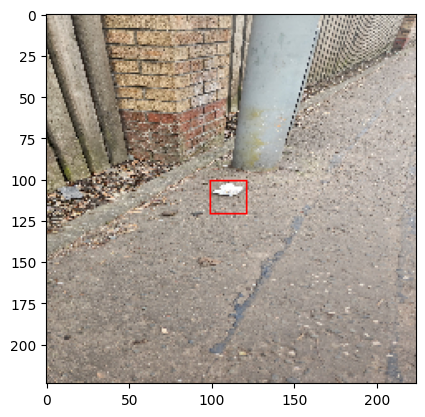

In [15]:
for count, annotated_file in enumerate(annotated_punalur_falkirk_files):
    # Extracting file name to fetch the corresponding raw image
    file_name = list(annotated_file.keys())[0]
    print(file_name)

    # Reading the corresponding raw image
    image_path = os.path.join(punalur_falkirk_raw_image_path, file_name.replace(".txt", ".jpg"))
    base_image = cv2.imread(image_path)

    if base_image is None:
        continue
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
    copy_image = base_image.copy()
    copy_image = resize_image(copy_image, (224, 224))

    box_values_from_annot_file = []

    for entry in annotated_file:

        # Iterating through each lines of the annotated file(ie, different object labels)
        df = annotated_file[entry]
        for index, row in df.iterrows():
            class_label = row['label_class']
            x_center = row['x_center']
            y_center = row['y_center']
            height = row['height']
            width = row['width']
            x1, y1, x2, y2 = get_rectangle_coordinates_from_image(copy_image, x_center, y_center, height, width)
            print('check')
            print(x1, y1, x2, y2)
            box_obj = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
            box_values_from_annot_file.append(box_obj)
            cv2.rectangle(copy_image, (x1, y1), (x2, y2), (255, 0, 0), 1)

    print(copy_image.shape)
    plt.imshow(copy_image)
    plt.show()
    if count == 5:
        break


In [16]:
"""Function to return the cropped and resized Image suitable for the classifier VGG16"""


def rectang_from_image(image, x, y, w, h):
    timage = image[y: y + h, x: x + w]
    resized = cv2.resize(timage,
                         (224, 224),
                         interpolation=cv2.INTER_AREA)
    return resized


In [17]:
image_list = os.listdir(punalur_falkirk_raw_image_path)


In [18]:
#Maximum proposals and samples to consider
max_proposal = 2000
max_samples = 200

#Defining the threshold values to distinguish the litter and background
IOU_treshold_litter = 0.7
IOU_treshold_background = 0.3


train_images=[]
train_labels=[]

In [19]:
"""Given an annotated .txt file and corresponding Image, 
this function returns the coordinates of the bounding box for image"""

def get_annotation_coord_from_txt(annotated_file, image):
    box_values_from_annot_file = []

    for index, row in annotated_file.iterrows():
        class_label = row['label_class']
        x_center = row['x_center']
        y_center = row['y_center']
        height = row['height']
        width = row['width']
        x1, y1, x2, y2 = get_rectangle_coordinates_from_image(image, x_center, y_center, height, width)
        box_obj = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
        box_values_from_annot_file.append(box_obj)
    return box_values_from_annot_file


In [20]:
"""Given an annotated .txt file and corresponding image,
this function calls get_annotation_coord_from_txt() for proper coordinates or return [] if file does not exist"""

def find_and_get_box_values_from_txt(file_name, image):
    annot_file = pd.DataFrame()
    for item in annotated_punalur_falkirk_files:
        # checking if file_name is in the dictionary key
        if file_name in item:
            annot_file = item[file_name]
            break

    if annot_file.empty:
        print(f'No Litter Image and the file is {file_name}')
        return [{"x1": 0, "y1": 0, "x2": 0, "y2": 0}]
    else:
        box_values = get_annotation_coord_from_txt(annot_file, image)
        return box_values


**Creating Dataset for Training**

In [21]:
# Initializing the train images and train labels to populate with respective values

train_images = []
train_labels = []

# Iterating through each raw image
for count, image_file in enumerate(tqdm(image_list, "Processing Images")):
    try:
        box_values_from_annot_file = []

        image_to_process_path = os.path.join(punalur_falkirk_raw_image_path, image_file)
        image_ = cv2.imread(image_to_process_path)
        
        image_to_process = image_.copy()
        image_to_process = cv2.cvtColor(image_to_process, cv2.COLOR_BGR2RGB)

        #Performing preprocessing to the image
        image_to_process = perform_image_preprocessing(image_to_process)

        try_image = image_to_process.copy()
        try_image = resize_image(try_image, (224, 224))

        # Getting corresponding Annotation file
        annot_file_name = image_file.replace(".jpg", ".txt")
        coordinates_from_annot_file = find_and_get_box_values_from_txt(annot_file_name, try_image)
        
        #handling images without any litter
        # no_litter_image = False
        # if len(coordinates_from_annot_file) == 0:
        #     # print("Annot file not present")
        #     no_litter_image = True
        #     # continue
        box_values_from_annot_file.extend(coordinates_from_annot_file)

        #Performing Region Proposal and getting the result 
        selective_search_results = perform_region_proposal(try_image)

        counter = flag = falsecounter = fflag = bflag = 0
        
        for e, result in enumerate(selective_search_results):
            if e < max_proposal and flag == 0:
                for a_box in box_values_from_annot_file:
                    x, y, w, h = result
                    
                    
                    #If there are no litters, skipping IOU operation and 
                    #adding cropped images to the train_images with label as 0
                    # if no_litter_image ==  True:
                    #   if falsecounter < max_samples:
                    #     train_images.append(rectang_from_image(try_image, x, y, w, h))
                    #     train_labels.append(0)
                    #   continue

                    #Calculating the IOU value of Region propsal results 
                    #and annotated file coordinates(ground truth)
                    iou = calculate_iou(a_box, {"x1": x, "x2": x + w, "y1": y, "y2": y + h})
                    if counter < max_samples:
                        if iou >= IOU_treshold_litter:
                            train_images.append(rectang_from_image(try_image, x, y, w, h))
                            train_labels.append(1)
                            counter += 1
                    else:
                        fflag = 1
                    if falsecounter < max_samples:
                        if iou < IOU_treshold_background:
                            train_images.append(rectang_from_image(try_image, x, y, w, h))
                            train_labels.append(0)
                            falsecounter += 1
                    else:
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    flag = 1

    except:
        print(f'Exception for the file {image_file}')


Processing Images:   0%|          | 0/236 [00:00<?, ?it/s]

No Litter Image and the file is IMG_4414.txt
No Litter Image and the file is IMG_4413.txt
No Litter Image and the file is IMG_4300.txt
No Litter Image and the file is 3.txt
No Litter Image and the file is 1.txt
No Litter Image and the file is 4.txt
No Litter Image and the file is IMG_4496.txt
No Litter Image and the file is 5.txt
No Litter Image and the file is 2.txt
No Litter Image and the file is 11.txt
No Litter Image and the file is 6.txt
No Litter Image and the file is 7.txt
No Litter Image and the file is 8.txt
No Litter Image and the file is 10.txt
No Litter Image and the file is 9.txt
No Litter Image and the file is IMG_0606.txt
No Litter Image and the file is IMG_0769.txt
No Litter Image and the file is IMG_1191.txt
No Litter Image and the file is IMG_1813.txt
No Litter Image and the file is IMG_2305.txt
No Litter Image and the file is IMG_2205.txt
No Litter Image and the file is IMG_2578.txt
No Litter Image and the file is IMG_1812.txt
No Litter Image and the file is IMG_2023

In [38]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

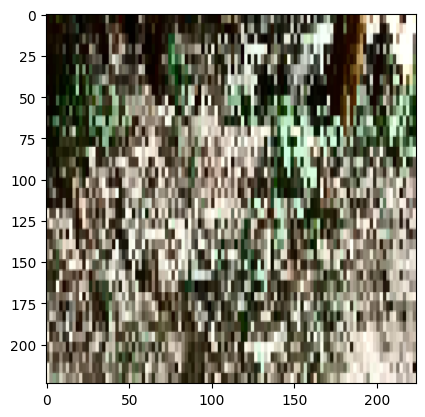

In [23]:
plt.imshow(X_new[-3])

In [24]:
print(len(X_new))

47452


In [25]:
print(y_new[-3])

0


In [26]:
print(len(y_new))
print(y_new[y_new == 1])

47452
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Using Pre-trained VGG16 Classifier and fine tuning

In [27]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
    
X= vggmodel.layers[-2].output
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()

553467096/553467096 [==============================] - 2s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Defining the training and testing data

Split the dataset in train and test / validation set. 

In [28]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

X_train, X_test , y_train, y_test = train_test_split(X_new,y_new,test_size=0.10)

In [29]:
print(X_train.shape)

(42706, 224, 224, 3)


## Performing Data Augmentation

In [30]:
trdata    = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=0)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata    = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=0)
testdata  = tsdata.flow(x=X_test, y=y_test)

## Training the R-CNN architecture

In [31]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')

hist = model_final.fit_generator(generator= traindata,
                                 steps_per_epoch= 10,
                                 epochs= 10, 
                                 validation_data= testdata,
                                 validation_steps=2,
                                 callbacks=[checkpoint,early])

Epoch 1/10


<ipython-input-31-bc9e401fab87>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata,


 9/10 [==========================>...] - ETA: 0s - loss: 576.9805 - accuracy: 0.6944
Epoch 1: val_loss improved from inf to 0.00000, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 19s 443ms/step - loss: 519.2824 - accuracy: 0.7250 - val_loss: 3.3270e-07 - val_accuracy: 1.0000
Epoch 2/10
 9/10 [==========================>...] - ETA: 0s - loss: 2.5101e-09 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
10/10 [==============================] - 0s 41ms/step - loss: 2.2591e-09 - accuracy: 1.0000 - val_loss: 105.7055 - val_accuracy: 0.9844
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 72.5053 - accuracy: 0.8819
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 4s 471ms/step - loss: 65.2548 - accuracy: 0.8938 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
 9/10 [==========================>...] - ETA: 0s - loss: 10.2925 - accuracy: 0.993

## Saving the final model

In [32]:
from IPython.display import HTML
def create_download_link(title = "Download model file", filename = './RNN_model.h5'):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)


model_final.save('./RNN_model.h5')
# create a link to download the model 
create_download_link(filename='./RNN_model.h5')

## Visualisation of the training process

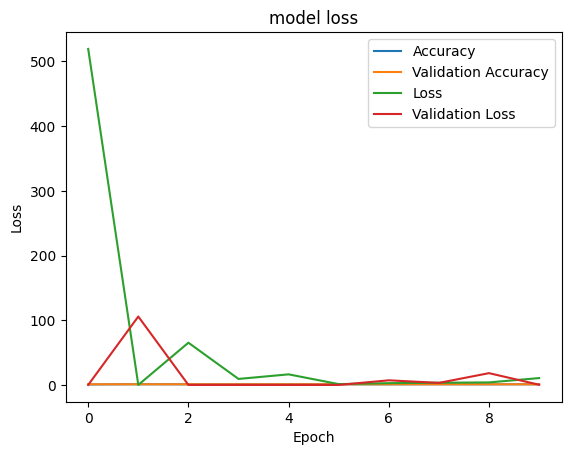

In [33]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss","Validation Loss"])
plt.show()

## Task 12: Prediction

In [50]:
ssresults = []
higher = []


1/1 [==============================] - 0s 21ms/step
[[0.9997243]]
1/1 [==============================] - 0s 21ms/step
[[0.99981254]]
1/1 [==============================] - 0s 21ms/step
[[0.999843]]
1/1 [==============================] - 0s 21ms/step
[[0.99996066]]
1/1 [==============================] - 0s 21ms/step
[[0.99925107]]
1/1 [==============================] - 0s 21ms/step
[[0.9995357]]
1/1 [==============================] - 0s 22ms/step
[[0.9998882]]
1/1 [==============================] - 0s 22ms/step
[[0.9997737]]
1/1 [==============================] - 0s 21ms/step
[[0.99913317]]
1/1 [==============================] - 0s 23ms/step
[[0.9990189]]
1/1 [==============================] - 0s 27ms/step
[[0.9997875]]
1/1 [==============================] - 0s 21ms/step
[[0.9991737]]
1/1 [==============================] - 0s 21ms/step
[[0.9997476]]
1/1 [==============================] - 0s 21ms/step
[[0.99940574]]
1/1 [==============================] - 0s 22ms/step


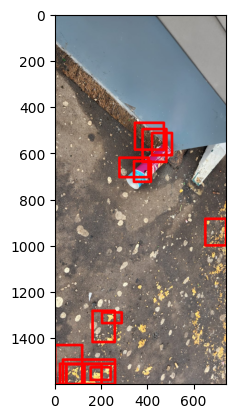

In [51]:
# img=random.choice(images)
img = cv2.imread(raw_image_path + '/test/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.imread(os.path.join(path,img))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
# ss.switchToSelectiveSearchFast()
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.999:
          print(out)
          higher.append(out[0][0])
          cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 10, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

In [52]:
print(higher)

[0.9997243, 0.99981254, 0.999843, 0.99996066, 0.99925107, 0.9995357, 0.9998882, 0.9997737, 0.99913317, 0.9990189, 0.9997875, 0.9991737, 0.9997476, 0.99940574]


In [53]:
print(np.max(higher))

0.99996066
